In [1]:
import ase.db
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from DIP16 import DIP16
import numpy as np

def calc_errors(calc,ref):
    me = 0
    mae = 0
    for i in range(len(calc)): 
        #print(calc[i],ref[i])
        tmp = calc[i]-ref[i]
        me += tmp 
        mae += abs(tmp) 
    me = me/len(calc)
    mae = mae/len(calc)
    #print('ME: {} MAE: {}'.format(me,mae))
    return me, mae 
ref = [2.013, 0.000, 1.040, 0.000, 1.760, 1.460, 0.000, 3.690, 0.000, 0.574, 1.205, 0.000, 1.565, 0.565, 0.000, 0.000]

In [2]:
def get_dataset(db,output_key,relaxed,mode,grid,init_orbs,xc,basis,verbose=0):
    """
        Get a specific property for all database (db) entries 
    """
    #print(db,output_key,relaxed,mode,grid,init_orbs,xc,basis)
    db = ase.db.connect(db)
    #print(db)
    x = []
    y = []
    z = []
    for row in db.select(relaxed=relaxed,mode=mode,grid=grid,init_orbs=init_orbs,xc=xc,basis=basis): 
        #print(row.name,row.mode,row.xc,row.basis,row.dipolemom,row.energy)
        x.append(row.name)
        if output_key == 'energy':
            y.append(row.energy)
        if output_key == 'dipolemom':
            y.append(row.dipolemom/0.2081943)
            z.append(row.dipole/0.2081943)
            
        if verbose > 3:
            if mode == 'DFT':
                init_orbs = mode
            print('{} {} {:10.2f} {:10.2f} {:10.2f} {:10.2f}'.format(row.name,init_orbs,row.dipolemom/0.2081943,z[-1][0],z[-1][1],z[-1][2]))
            
    return x,y,z

def get_entry(db,name,output_key,relaxed,mode,grid,init_orbs,xc,basis):
    """
        Get a specific property for single entry (name)
    """
    db = ase.db.connect(db)
    #print(db)
    for row in db.select(name=name,relaxed=relaxed,mode=mode,grid=grid,init_orbs=init_orbs,xc=xc,basis=basis): 
        if row.name == name: 
            x = row.name
        if output_key == 'energy':
            y = row.energy
        if output_key == 'dipolemom':
            y = row.dipolemom/0.2081943
            z = row.dipole/0.2081943
    return x,y,z

# Evaluate only LT or LDQ per molecules. Use lowest energy ones
def get_FOD_sets(db,db_sys,FOD_set,output_key,relaxed,mode,grid,xc,basis,verbose=0):
    """
        Get dipole for entry with specification (FOD_set)
    """
    sys = list(db_sys.keys())
    x = []
    y = []
    z = []
    db = ase.db.connect(db)
    for i,s in enumerate(sys): 
        e = +1e7
        for row in db.select(name=s,relaxed=relaxed,mode=mode,grid=grid,xc=xc,basis=basis):
            if row.name == s:
                # If the structure is either Lewis or Linnett
                # no Linnett structures for mol04, mol07, mol09
                if row.init_orbs[0:5] == FOD_set[0:5] or row.name in ['mol04','mol07','mol09']:
                    x_tmp = row.name
                    e_tmp = row.energy
                    dip_tmp = row.dipolemom/0.2081943
                    dip = row.dipole/0.2081943
                    if e_tmp < e:
                        e = e_tmp 
                        tmp_init_orbs  = row.init_orbs
                        y_tmp = dip_tmp 
                        z_tmp = dip        
        x.append(x_tmp)
        y.append(y_tmp)
        z.append(z_tmp)  
        
        if verbose > 3:
            print('{} {} {:10.2f} {:10.2f} {:10.2f} {:10.2f}'.format(s,FOD_set,y_tmp,z_tmp[0],z_tmp[1],z_tmp[2]))        
        
    return x,y,z
    
def get_FOD_lowest_energy(db,db_sys,output_key,relaxed,mode,grid,xc,basis,verbose=0):
    """
        Get dipole for entry with the lowest energy 
    """
    sys = list(db_sys.keys())
    x = []
    y = []
    z = []
    db = ase.db.connect(db)
    for i,s in enumerate(sys): 
        e = +1e7
        for row in db.select(name=s,relaxed=relaxed,mode=mode,grid=grid,xc=xc,basis=basis):
            if row.name == s: 
                x_tmp = row.name
                e_tmp = row.energy
                dip_tmp = row.dipolemom/0.2081943
                dip = row.dipole/0.2081943
                if e_tmp < e: 
                    e = e_tmp 
                    tmp_init_orbs  = row.init_orbs
                    y_tmp = dip_tmp 
                    z_tmp = dip
                    
        x.append(x_tmp)
        y.append(y_tmp)
        z.append(z_tmp)
        
        if verbose > 3:
            print('{} {} {:10.2f} {:10.2f} {:10.2f} {:10.2f}'.format(s,'Emin',y_tmp,z_tmp[0],z_tmp[1],z_tmp[2]))
    return x,y,z
    

In [19]:
# Print absolute dipole and components
# calculate ME and MAE
# DFT
x,y,z = get_dataset(db='DIP16_PyFLOSIC.db',output_key='dipolemom',relaxed=False,mode='DFT',grid='level=7',init_orbs='Lewis1',xc='LDA',basis='pc-1',verbose=4)
me,mae = calc_errors(y,ref)
print('{} ME: {:6.2f} MAE: {:6.2f}'.format('DFT',me,mae))

mol01 DFT       1.94       0.27       1.43      -1.28
mol02 DFT       0.00       0.00      -0.00       0.00
mol03 DFT       0.96      -0.46       0.66      -0.53
mol04 DFT       0.00      -0.00       0.00      -0.00
mol05 DFT       1.76       0.29      -1.71       0.27
mol06 DFT       1.38      -0.96       0.98      -0.08
mol07 DFT       0.00       0.00      -0.00       0.00
mol08 DFT       3.17      -2.91       1.25      -0.02
mol09 DFT       0.00      -0.00       0.00      -0.00
mol10 DFT       0.64      -0.31       0.43       0.36
mol11 DFT       1.42       0.89      -0.24       1.09
mol12 DFT       0.00      -0.00       0.00      -0.00
mol13 DFT       1.15       0.71       0.91       0.00
mol14 DFT       0.43      -0.01      -0.06      -0.43
mol15 DFT       0.00      -0.00      -0.00      -0.00
mol16 DFT       0.00      -0.00       0.00       0.00
DFT ME:  -0.06 MAE:   0.10


In [9]:
# Print absolute dipole and components
# calculate ME and MAE
# FLO-SIC, using the E_min classifier
x,y,z = get_FOD_lowest_energy(db='DIP16_PyFLOSIC.db',db_sys=DIP16,output_key='dipolemom',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',verbose=4)
me,mae = calc_errors(y,ref)
print('{} ME: {:6.2f} MAE: {:6.2f}'.format('FLO-SIC E_min',me,mae))

mol01 Emin       2.16      -0.21       1.70      -1.31
mol02 Emin       0.00       0.00      -0.00       0.00
mol03 Emin       0.59      -0.28       0.40      -0.32
mol04 Emin       0.00       0.00      -0.00       0.00
mol05 Emin       3.53       0.59      -3.44       0.54
mol06 Emin       1.33      -1.06       0.81      -0.01
mol07 Emin       0.02       0.02      -0.00       0.02
mol08 Emin       3.39      -3.12       1.34      -0.04
mol09 Emin       0.00      -0.00       0.00       0.00
mol10 Emin       0.49      -0.23       0.33       0.27
mol11 Emin       1.41       0.88      -0.23       1.08
mol12 Emin       1.05      -0.09       1.05       0.01
mol13 Emin       2.27       1.40       1.79      -0.00
mol14 Emin       1.02      -0.01      -0.14      -1.01
mol15 Emin       0.00      -0.00      -0.00      -0.00
mol16 Emin       0.00      -0.00       0.00       0.00
FLO-SIC E_min ME:   0.21 MAE:   0.33


In [10]:
# Print absolute dipole and components
# calculate ME and MAE
# FLO-SIC, using the LT classifier
x,y,z = get_FOD_sets(db='DIP16_PyFLOSIC.db',db_sys=DIP16,FOD_set='Lewis',output_key='dipolemom',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',verbose=4)
me, mae = calc_errors(y,ref)
print('{} ME: {:6.2f} MAE: {:6.2f}'.format('FLO-SIC LT',me,mae))


mol01 Lewis       2.16      -0.21       1.70      -1.31
mol02 Lewis       0.00       0.00      -0.00       0.00
mol03 Lewis       0.68      -0.22       0.52      -0.37
mol04 Lewis       0.00       0.00      -0.00       0.00
mol05 Lewis       3.53       0.59      -3.44       0.54
mol06 Lewis       1.33      -1.06       0.81      -0.01
mol07 Lewis       0.02       0.02      -0.00       0.02
mol08 Lewis       3.39      -3.12       1.34      -0.04
mol09 Lewis       0.00      -0.00       0.00       0.00
mol10 Lewis       0.37      -0.18       0.25       0.20
mol11 Lewis       1.08       0.67      -0.18       0.82
mol12 Lewis       1.05      -0.09       1.05       0.01
mol13 Lewis       2.27       1.40       1.79      -0.00
mol14 Lewis       1.02      -0.01      -0.14      -1.01
mol15 Lewis       0.00      -0.00      -0.00      -0.00
mol16 Lewis       0.00      -0.00       0.00       0.00
FLO-SIC LT ME:   0.19 MAE:   0.33


In [11]:
# Print absolute dipole and components
# calculate ME and MAE
# FLO-SIC, using the LDQ classifier
x,y,z = get_FOD_sets(db='DIP16_PyFLOSIC.db',db_sys=DIP16,FOD_set='Linnett',output_key='dipolemom',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',verbose=4)
me, mae = calc_errors(y,ref)
print('{} ME: {:6.2f} MAE: {:6.2f}'.format('FLO-SIC LDQ',me,mae))

mol01 Linnett       2.19       0.31       1.62      -1.45
mol02 Linnett       0.01       0.01      -0.00      -0.00
mol03 Linnett       0.59      -0.28       0.40      -0.32
mol04 Linnett       0.00       0.00      -0.00       0.00
mol05 Linnett       2.06       0.34      -2.01       0.31
mol06 Linnett       1.32      -1.07       0.78       0.00
mol07 Linnett       0.02       0.02      -0.00       0.02
mol08 Linnett       3.77      -3.47       1.49      -0.04
mol09 Linnett       0.00      -0.00       0.00       0.00
mol10 Linnett       0.49      -0.23       0.33       0.27
mol11 Linnett       1.41       0.88      -0.23       1.08
mol12 Linnett       0.00       0.00      -0.00      -0.00
mol13 Linnett       1.29       0.80       1.02       0.00
mol14 Linnett       0.49      -0.00      -0.07      -0.48
mol15 Linnett       0.00       0.00       0.00       0.00
mol16 Linnett       0.00      -0.00       0.00       0.00
FLO-SIC LDQ ME:  -0.01 MAE:   0.11


**Figure 3**
- currently PyFLOSIC database includes the initial FODs 

In [3]:
from my_viewer import MyView
from ase.atoms import Atoms
from ipywidgets import interact, interactive, fixed, interact_manual

def my_view(ase_atoms): 
    return MyView(ase_atoms)

def get_system_FOD_lowest_energy(db,db_sys,relaxed,mode,grid,xc,basis,rot):
    sys = list(db_sys.keys())
    Structs = {}
    db = ase.db.connect(db)
    for i,s in enumerate(sys): 
        e = +1e7
        low_energy_atoms = None
        for row in db.select(name=s,relaxed=relaxed,mode=mode,grid=grid,xc=xc,basis=basis):
            if row.name == s: 
                x_tmp = row.name
                e_tmp = row.energy
                dip_tmp = row.dipolemom/0.2081943
                atoms = Atoms(symbols=row.symbols,positions=row.positions)
                #atoms.center(vacuum=row.vac)
                #atoms.set_pbc(False)
 
                atoms.energy = row.energy 
                atoms.dipole = row.dipole
                atoms.dipolemom = row.dipolemom
                atoms.name = row.name #'{}-{}-{}-{}-{}'.format(row.name,row.mode,row.basis,row.h,row.xc)
                atoms.rot_x,atoms.rot_y,atoms.rot_z,atoms.zoom = rot[row.name]
                atoms.dip_color = dct_dip_colors[row.init_orbs]
                if e_tmp < e: 
                    e = e_tmp 
                    low_energy_atoms = atoms
                    
        Structs.update({row.name : low_energy_atoms})
    return Structs

def get_system_FOD_set(db,db_sys,FOD_set,relaxed,mode,grid,xc,basis,rot):
    db = ase.db.connect(db)
    Structs = {}
    sys = list(db_sys.keys())
    x = []
    y = []
    for i,name in enumerate(sys):
        e = +1e7
        init_orbs = FOD_set
        
        #print(name,init_orbs)
        for row in db.select(name=name,relaxed=relaxed,mode=mode,grid=grid,xc=xc,basis=basis):
        #for row in db.select(name=name,relaxed=relaxed,mode=mode,grid=grid,init_orbs=init_orbs,xc=xc,basis=basis):
            if row.init_orbs[0:5] == FOD_set[0:5] or row.name in ['mol04','mol07','mol09']:
                x_tmp = row.name
                e_tmp = row.energy
                dip_tmp = row.dipolemom/0.2081943
                atoms = Atoms(symbols=row.symbols,positions=row.positions)
                #atoms.center(vacuum=row.vac)
                #atoms.set_pbc(False)
 
                atoms.energy = row.energy 
                atoms.dipole = row.dipole
                atoms.dipolemom = row.dipolemom
                atoms.name = row.name #'{}-{}-{}-{}-{}'.format(row.name,row.mode,row.basis,row.h,row.xc)
                atoms.rot_x,atoms.rot_y,atoms.rot_z,atoms.zoom = rot[row.name]
                atoms.dip_color = dct_dip_colors[init_orbs]
                if e_tmp < e: 
                    e = e_tmp 
                    low_energy_atoms = atoms
                Structs.update({row.name : low_energy_atoms})
    return Structs 


def get_system(db,relaxed,mode,grid,init_orbs,xc,basis,rot):
    db = ase.db.connect(db)
    Structs = {}
    for row in db.select(relaxed=relaxed,mode=mode,grid=grid,init_orbs=init_orbs,xc=xc,basis=basis): 
        atoms = Atoms(symbols=row.symbols,positions=row.positions)
        #atoms.center(vacuum=row.vac)
        #atoms.set_pbc(False)
 
        atoms.energy = row.energy 
        atoms.dipole = row.dipole
        atoms.dipolemom = row.dipolemom
        atoms.name = row.name #'{}-{}-{}-{}-{}'.format(row.name,row.mode,row.basis,row.h,row.xc)
        atoms.rot_x,atoms.rot_y,atoms.rot_z,atoms.zoom = rot[row.name]
        atoms.dip_color = dct_dip_colors[init_orbs]
        Structs.update({row.name : atoms})
    return Structs 

def view_structure(structures):
    myview = my_view(structures)
    myview.rotate_view(x=structures.rot_x,y=structures.rot_y,z=structures.rot_z)
    myview.dip_color = structures.dip_color
    myview.d1.value = structures.dip_color
    myview.display()
    #display(myview.view)
    return my_view 


dct_dip_colors =  {'DFT' : 'blue',
                   'Lewis1' : 'tomato',
                   'Lewis' : 'tomato',
                   'Linnett2': 'darkgreen' ,
                   'Linnett1': 'lightgreen',
                   'Linnett': 'lightgreen',
                   'Lewis2' : 'lightpink',
                   'Lewis4' : 'violett',
                   'Lewis3' : 'orange',
                   'FB' : 'darkgrey'}


rot_DIP16 = {'mol01' : [39,-5,15,0], 
             'mol02' : [29,12,0,0], 
             'mol03' : [-5,-29,-124,0],
             'mol04' : [77,30,-10,0], 
             'mol05' : [5,-10,260,0],
             'mol06' : [-16,165,-21,0], 
             'mol07' : [-10,25,59,0],
             'mol08' : [0,0,203,0],
             'mol09' : [-20,30,60,0], 
             'mol10' : [-48,45,5,0],
             'mol11' : [32,51,15,0],
             'mol12' : [9,0,85,0], 
             'mol13' : [0,0,128,0], 
             'mol14' : [90,89,0,0],
             'mol15' : [10,0,0,0], 
             'mol16' : [10,0,0,0]}



#
# Display the molecular geometry,
# the FODs, and the corresponding dipole
#

# Emin: Lowest energy solution
#structs = get_system_FOD_lowest_energy(db='DIP16_PyFLOSIC.db',db_sys=DIP16,relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',rot=rot_DIP16)
# LT: FODs from mol files, LT
structs = get_system_FOD_set(db='DIP16_PyFLOSIC.db',db_sys=DIP16,FOD_set='Lewis',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',rot=rot_DIP16)
# LDQ: LDQ FODs whenever available
#structs = get_system_FOD_set(db='DIP16_PyFLOSIC.db',db_sys=DIP16,FOD_set='Linnett',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',rot=rot_DIP16)

# Show only a given electronic geometry
#structs = get_system(db='DIP16_PyFLOSIC.db',relaxed=False,mode='FLO-SIC',grid='level=7',init_orbs='Lewis1',xc='LDA',basis='pc-1',rot=rot_DIP16)
#structs = get_system(db='DIP16_PyFLOSIC.db',relaxed=False,mode='FLO-SIC',grid='level=7',init_orbs='Lewis2',xc='LDA',basis='pc-1',rot=rot_DIP16)
#structs = get_system(db='DIP16_PyFLOSIC.db',relaxed=False,mode='FLO-SIC',grid='level=7',init_orbs='Lewis3',xc='LDA',basis='pc-1',rot=rot_DIP16)
#structs = get_system(db='DIP16_PyFLOSIC.db',relaxed=False,mode='FLO-SIC',grid='level=7',init_orbs='Lewis4',xc='LDA',basis='pc-1',rot=rot_DIP16)
#structs = get_system(db='DIP16_PyFLOSIC.db',relaxed=False,mode='FLO-SIC',grid='level=7',init_orbs='Linnett1',xc='LDA',basis='pc-1',rot=rot_DIP16)
#structs = get_system(db='DIP16_PyFLOSIC.db',relaxed=False,mode='FLO-SIC',grid='level=7',init_orbs='Linnett2',xc='LDA',basis='pc-1',rot=rot_DIP16)
interact(view_structure, structures=structs)

interactive(children=(Dropdown(description='structures', options={'mol01': Atoms(symbols='C13H9He47NX47', pbc=…

<function __main__.view_structure(structures)>

mol01 Lewis1 2.1578
mol02 Lewis2 0.0026
mol03 Linnett1 0.5878
mol04 Lewis1 0.0001
mol05 Lewis1 3.5345
mol06 Lewis1 1.332
mol07 Lewis1 0.025
mol08 Lewis1 3.4056
mol09 Lewis1 0.0046
mol10 Linnett2 0.488
mol11 Linnett1 1.4064
mol12 Lewis2 1.0492
mol13 Lewis1 2.272
mol14 Lewis1 1.0169

In [14]:
# Generate Figures for all molecules, including the dipole moments

import time
from ipywidgets import GridBox, Layout

dct_colors = {'blue': [0, 1, 1],
              'tomato' : [255/255, 99/255, 71/255],
              'lightgreen' : [144/255,238/255,144/255],
              'lightpink' : [255/255,182/255,193/255],
              'violett' : [173/255, 149/255, 243/255],
              'orange': [230/255, 107/255, 25/255]}

class Parameters: 
    def __init__(self): 
        self.FODs_equal_digits = 3 
        self.FOD_up = 'X'
        self.FOD_dn = 'He'
        self.r_FOD = 0.1
        self.dip_color = dct_colors['lightgreen']
        self.dip_radius = 0.2 
        self.rot_x = 0 
        self.rot_y = 0 
        self.rot_z = 0
        self.zoom = 0 
        self.output_name = 'screenshot'

def plot_structures_DIP16(ase_atoms,p): 
    myview = my_view(ase_atoms)
    myview.rotate_view(x=ase_atoms.rot_x,y=ase_atoms.rot_y,z=ase_atoms.rot_z)  
    myview.dip_color = ase_atoms.dip_color
    myview.d1.value = ase_atoms.dip_color
    myview.on_click_dipole(myview.b2)
    myview.s2.value = 0.53
    myview.on_click_ball_and_stick(myview.b3)
    myview.on_click_screenshot(myview.b1)
    return myview 
    
rot_DIP16 = {'mol01' : [39,-5,15,0], 
             'mol02' : [29,12,0,0], 
             'mol03' : [-5,-29,-124,0],
             'mol04' : [77,30,-10,0], 
             'mol05' : [5,-10,260,0],
             'mol06' : [-16,165,-21,0], 
             'mol07' : [-10,25,59,0],
             'mol08' : [0,0,203,0],
             'mol09' : [-20,30,60,0], 
             'mol10' : [-48,45,5,0],
             'mol11' : [32,51,15,0],
             'mol12' : [9,0,85,0], 
             'mol13' : [0,0,128,0], 
             'mol14' : [90,89,0,0],
             'mol15' : [10,0,0,0], 
             'mol16' : [10,0,0,0]}

def run():
    # Choose which FODs to use
    #FLOSIC_Emin = get_system_FOD_lowest_energy(db='DIP16_PyFLOSIC.db',db_sys=DIP16,relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',rot=rot_DIP16)
    #FLOSIC_LT = get_system_FOD_set(db='DIP16_PyFLOSIC.db',db_sys=DIP16,FOD_set='Lewis',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',rot=rot_DIP16)
    FLOSIC_LDQ = get_system_FOD_set(db='DIP16_PyFLOSIC.db',db_sys=DIP16,FOD_set='Linnett',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',rot=rot_DIP16)
    DATA = FLOSIC_LDQ
    p = Parameters()
    sys = list(DATA.keys()) 
    TMP = []
    for s in sys: 
        ase_atoms = DATA[s]
        p.rot_x, p.rot_y, p.rot_z, p.zoom = rot_DIP16[s]
        tmp = plot_structures_DIP16(ase_atoms,p=p)
        display(tmp.view)
        TMP.append(tmp.view)
        time.sleep(1)

run()
time.sleep(10)


NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

mol01 DFT       1.94       0.27       1.43      -1.28
mol02 DFT       0.00       0.00      -0.00       0.00
mol03 DFT       0.96      -0.46       0.66      -0.53
mol04 DFT       0.00      -0.00       0.00      -0.00
mol05 DFT       1.76       0.29      -1.71       0.27
mol06 DFT       1.38      -0.96       0.98      -0.08
mol07 DFT       0.00       0.00      -0.00       0.00
mol08 DFT       3.17      -2.91       1.25      -0.02
mol09 DFT       0.00      -0.00       0.00      -0.00
mol10 DFT       0.64      -0.31       0.43       0.36
mol11 DFT       1.42       0.89      -0.24       1.09
mol12 DFT       0.00      -0.00       0.00      -0.00
mol13 DFT       1.15       0.71       0.91       0.00
mol14 DFT       0.43      -0.01      -0.06      -0.43
mol15 DFT       0.00      -0.00      -0.00      -0.00
mol16 DFT       0.00      -0.00       0.00       0.00
mol01 Emin       2.16      -0.21       1.70      -1.31
mol02 Emin       0.00       0.00      -0.00       0.00
mol03 Emin       0.59     

<IPython.core.display.Javascript object>


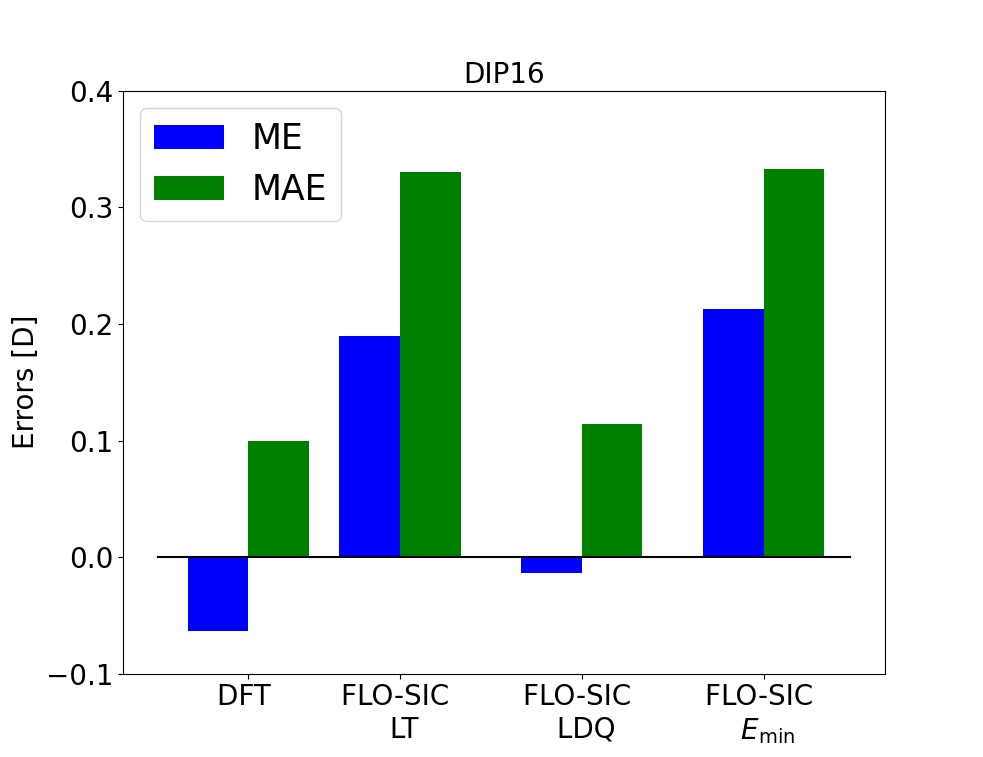

In [5]:
# DIP16 errors 
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
# our data 
# DFT 
#x,y,z = get_FOD_sets(db='DIP16_PyFLOSIC.db',db_sys=DIP16,FOD_set=FOD_sets[0],output_key='dipolemom',relaxed=False,mode='DFT',grid='level=7',xc='LDA',basis='pc-1')
x,y,z = get_dataset(db='DIP16_PyFLOSIC.db',output_key='dipolemom',relaxed=False,mode='DFT',grid='level=7',init_orbs='Lewis1',xc='LDA',basis='pc-1',verbose=4)
DFT = calc_errors(y,ref)
#
x,y,z = get_FOD_lowest_energy(db='DIP16_PyFLOSIC.db',db_sys=DIP16,output_key='dipolemom',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',verbose=4)
Emin = calc_errors(y,ref)
#
x,y,z = get_FOD_sets(db='DIP16_PyFLOSIC.db',db_sys=DIP16,FOD_set='Lewis',output_key='dipolemom',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',verbose=4)
LT = calc_errors(y,ref)
#
x,y,z = get_FOD_sets(db='DIP16_PyFLOSIC.db',db_sys=DIP16,FOD_set='Linnett',output_key='dipolemom',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',verbose=4)
LDQ = calc_errors(y,ref)


fig, ax = plt.subplots()
ax.set_title('DIP16',fontsize=20)
width=0.35
x = np.array([0.35,3.5*width,6.5*width,9.5*width])
# values paper supplement S4
LDA = np.array([DFT[0],LT[0],LDQ[0],Emin[0]])
LDAFLOSIC= np.array([DFT[1],LT[1],LDQ[1],Emin[1]])
labels = ["DFT \n ","FLO-SIC \n LT","FLO-SIC \n LDQ","FLO-SIC \n $E_{\mathrm{min}}$"]
ax.plot([0,4.],[0,0],color='black')
ax.bar(x,LDA,width=width,color='blue',label='ME')
ax.bar(x+width,LDAFLOSIC,width=width,color='green',label='MAE')
ax.set_xticks(x+width/2)
ax.set_xticklabels(labels)
ax.set_ylabel('Errors [D]',fontsize=20)
ax.set_ylim([-0.1,0.4])
ax.legend(loc=2,fontsize=25)

<IPython.core.display.Javascript object>


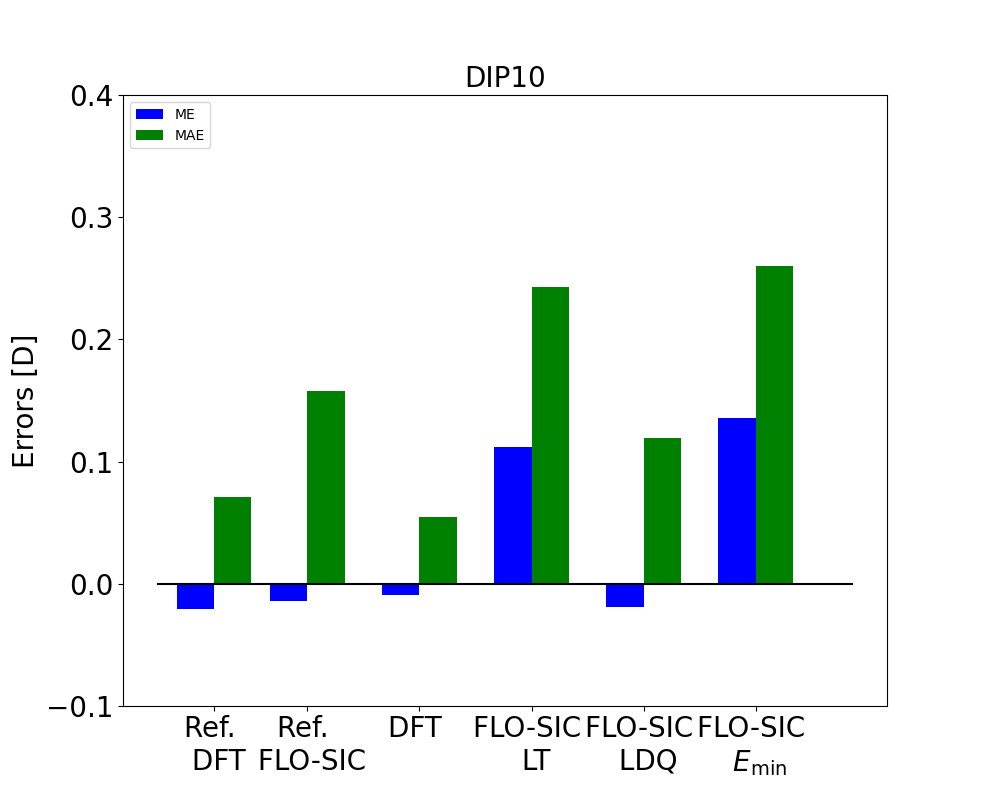

In [5]:
# DIP10 errors to compare with paper 

import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

# UTEP errors 
# Ref. https://aip-prod-cdn.literatumonline.com/journals/content/jcp/2020/jcp.2020.153.issue-18/5.0024776/20201109/suppl/jcp20-ar-03171_supplementary_materials.pdf?b92b4ad1b4f274c70877518510abb28b4b52684e04957b0ffa32428805db72bf1ae006baafd3547213af4e27a9a05cbc37a77199d607a1ef1b0aa64328dafd49278e4c3fa4f6ee74505d57c3e40a5bf4ebd1399d4b9bfee96af13ca70c3a1e69ea5acfcaf4bf30cc8f0c4be9abd968066bdecf3412d6189742a7ca781e0d8870547c848c4f5ec063202a6b7a0ff78622598349fa677fa719dc0d738d06c03a7121a582cb
# SS: double chheck needed 
DIP10   = {'mol01' : 1.94,
           'mol02' : 0.00,
           'mol03' : 1.08,
           'mol04' : 0.00,
           #'mol05' : None,
           'mol06' : 1.46, 
           'mol07' : 0.00,
           #'mol08' : None,
           'mol09' : 0.00,
           #'mol10' : None,
           'mol11' : 1.20, 
           'mol12' : 0.00, 
           #'mol13' : None,
           'mol14' : 0.55}
utep_lda = {'mol01' : 1.91,
           'mol02' : 0.00,
           'mol03' : 0.87,
           'mol04' : 0.0,
           #'mol05' : None,
           'mol06' : 1.35, 
           'mol07' : 0.00,
           #'mol08' : None,
           'mol09' : 0.00,
           #'mol10' : None,
           'mol11' : 1.45, 
           'mol12' : 0.00, 
           #'mol13' : None,
           'mol14' : 0.44}

utep_flosic = {'mol01' : 1.94,
               'mol02' : 0.03,
               'mol03' : 0.56,
               'mol04' : 0.00,
               #'mol05' : None,
               'mol06' : 1.26, 
               'mol07' : 0.02,
               #'mol08' : None,
               'mol09' : 0.02,
               #'mol10' : None,
               'mol11' : 1.06, 
               'mol12' : 0.07, 
               #'mol13' : None,
               'mol14' : 1.13}
def errors_dct(ref,calc):
    keys = list(ref.keys())
    me = 0
    mae = 0
    for k in keys: 
        if ref[k] is not None: 
            tmp = calc[k] - ref[k]  
            me += tmp 
            mae += abs(tmp)
    me = me/len(keys)
    mae = mae/len(keys)
    return me, mae 

UTEP_LDA_errors = errors_dct(DIP10,utep_lda)
#print(UTEP_LDA_errors)
UTEP_FLOSIC_errors = errors_dct(DIP10,utep_flosic)
#print(UTEP_FLOSIC_errors)
x,y,z = get_dataset(db='DIP16_PyFLOSIC.db',output_key='dipolemom',relaxed=False,mode='DFT',grid='level=7',init_orbs='Lewis1',xc='LDA',basis='pc-1',verbose=3)
DFT_values = dict(zip(x,y))
DFT_errors = errors_dct(DIP10,DFT_values)

x,y,z = get_FOD_lowest_energy(db='DIP16_PyFLOSIC.db',db_sys=DIP16,output_key='dipolemom',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',verbose=3)
Emin_values = dict(zip(x,y))
Emin_errors = errors_dct(DIP10,FOD1_values)
#
x,y,z = get_FOD_sets(db='DIP16_PyFLOSIC.db',db_sys=DIP16,FOD_set='Lewis',output_key='dipolemom',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',verbose=3)
LT_values = dict(zip(x,y))
LT_errors = errors_dct(DIP10,FOD2_values)
#
x,y,z = get_FOD_sets(db='DIP16_PyFLOSIC.db',db_sys=DIP16,FOD_set='Linnett',output_key='dipolemom',relaxed=False,mode='FLO-SIC',grid='level=7',xc='LDA',basis='pc-1',verbose=3)
LDQ_values = dict(zip(x,y))
LDQ_errors = errors_dct(DIP10,FOD3_values)

fig, ax = plt.subplots()
ax.set_title('DIP10',fontsize=20)
width=0.35
x = np.array([0.35,3.5*width,6.5*width,9.5*width,12.5*width,15.5*width])
# values paper supplement S4
LDA = np.array([UTEP_LDA_errors[0],UTEP_FLOSIC_errors[0],DFT_errors[0],LT_errors[0],LDQ_errors[0],Emin_errors[0]])
LDAFLOSIC= np.array([UTEP_LDA_errors[1],UTEP_FLOSIC_errors[1],DFT_errors[1],LT_errors[1],LDQ_errors[1],Emin_errors[1]])
labels = ['Ref. \n DFT',"Ref. \n FLO-SIC","DFT \n ","FLO-SIC \n LT","FLO-SIC \n LDQ","FLO-SIC \n $E_{\mathrm{min}}$"]
ax.plot([0,6.5],[0,0],color='black')
ax.bar(x,LDA,width=width,color='blue',label='ME')
ax.bar(x+width,LDAFLOSIC,width=width,color='green',label='MAE')
ax.set_xticks(x+width/2)
ax.set_xticklabels(labels)
ax.set_ylabel('Errors [D]',fontsize=20)
ax.set_ylim([-0.1,0.4])
ax.legend(loc=2)